## **Assignment 3**

# Question 1

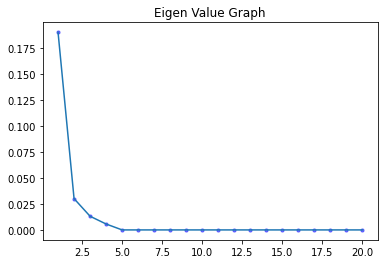

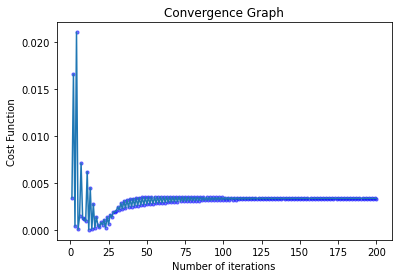


 Audio Signal 1 




 Audio Signal 2 




 Audio Signal 3 




 Audio Signal 4 



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA
import scipy.io.wavfile as wav
import librosa
from IPython.display import Audio

if __name__ == '__main__':
    X0, sr = librosa.load('/content/x_ica_1.wav', sr=None)
    X = np.zeros((20, len(X0)))
    X[0] = X0
    X[1], sr = librosa.load('/content/x_ica_2.wav', sr=None)
    X[2], sr = librosa.load('/content/x_ica_3.wav', sr=None)
    X[3], sr = librosa.load('/content/x_ica_4.wav', sr=None)
    X[4], sr = librosa.load('/content/x_ica_5.wav', sr=None)
    X[5], sr = librosa.load('/content/x_ica_6.wav', sr=None)
    X[6], sr = librosa.load('/content/x_ica_7.wav', sr=None)
    X[7], sr = librosa.load('/content/x_ica_8.wav', sr=None)
    X[8], sr = librosa.load('/content/x_ica_9.wav', sr=None)
    X[9], sr = librosa.load('/content/x_ica_10.wav', sr=None)
    X[10], sr = librosa.load('/content/x_ica_11.wav', sr=None)
    X[11], sr = librosa.load('/content/x_ica_12.wav', sr=None)
    X[12], sr = librosa.load('/content/x_ica_13.wav', sr=None)
    X[13], sr = librosa.load('/content/x_ica_14.wav', sr=None)
    X[14], sr = librosa.load('/content/x_ica_15.wav', sr=None)
    X[15], sr = librosa.load('/content/x_ica_16.wav', sr=None)
    X[16], sr = librosa.load('/content/x_ica_17.wav', sr=None)
    X[17], sr = librosa.load('/content/x_ica_18.wav', sr=None)
    X[18], sr = librosa.load('/content/x_ica_19.wav', sr=None)
    X[19], sr = librosa.load('/content/x_ica_20.wav', sr=None)

    # Data Centring
    Mean = np.mean(X, axis=1)
    X_standardized = (X - np.mean(X, axis=1, keepdims=True))
    cov_matrix = np.cov(X_standardized)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sorting Eigen Values and Eigen Vectors
    sort_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sort_indices]
    sorted_eigenvalues = eigenvalues[sort_indices]

    x = np.linspace(1, 20, len(eigenvalues))

    plt.plot(x, eigenvalues)
    plt.scatter(x, eigenvalues, s=10, c='blue', edgecolor='blue', alpha=0.5)
    plt.title("Eigen Value Graph")
    plt.show()

    # Number of independent Components 
    # Decided on the basis of 4 largest Eigen Values
    k = 4

    # Whitening PCA
    whitened_matrix = sorted_eigenvectors[:, :k] / np.sqrt(sorted_eigenvalues[:k])
    Z = np.matmul(whitened_matrix.T, X_standardized) # whitened data

    # ICA Implementation using the provided equations
    N = np.shape(X[0])
    NI = np.eye(k)*N
    l_rate = 1e-5
    tol = 0.00001
    W = np.random.rand(k, k)
    W = W / LA.norm(W)
    Y = np.matmul(W, Z)
    error_array = []

    for iteration in range(200):
        gy = np.tanh(Y)
        fy = np.power(Y, 3)
        matrix = np.matmul(gy, fy.T)
        delta_W = np.matmul(NI - matrix, W)
        W_new = W + l_rate*delta_W
        Y = np.matmul(W_new, Z)
        error = abs(W - W_new)
        error = np.min(error)
        error_array.append(error)
        if error < tol:
            break
        W = W_new
        W = W / LA.norm(W)

    x = np.linspace(1, len(error_array), len(error_array))
    plt.plot(x, error_array)
    plt.scatter(x, error_array, s=10, c='blue', edgecolor='blue', alpha=0.5)
    plt.title("Convergence Graph")
    plt.xlabel("Number of iterations")
    plt.ylabel("Cost Function")
    plt.show()

    print("\n Audio Signal 1 \n")
    display(Audio(data=Y[0], rate=sr))
    print("\n Audio Signal 2 \n")
    display(Audio(data=Y[1], rate=sr))
    print("\n Audio Signal 3 \n")
    display(Audio(data=Y[2], rate=sr))
    print("\n Audio Signal 4 \n")
    display(Audio(data=Y[3], rate=sr))



# Question 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA
import scipy.io.wavfile as wav
import librosa
from IPython.display import Audio


def STFT(x):
    hop = 512
    win = 1024
    D = librosa.stft(x, n_fft=1024, hop_length=hop, win_length=win, window='hann')
    return D


def W_update(W, H, X):
    ones = np.ones((len(W), len(H[0])))
    WH = np.dot(W, H)
    Ht = np.transpose(H)
    num1 = np.divide(X, WH + 1e-20)
    num = np.dot(num1, Ht)
    den = np.dot(ones, Ht)
    deltaW = np.divide(num, den + 1e-20)
    W = W * deltaW
    return W


def H_update(W, H, X):
    ones = np.ones((len(W), len(H[0])))
    WH = np.dot(W, H)
    Wt = np.transpose(W)
    num1 = np.divide(X, WH + 1e-20)
    num = np.dot(Wt, num1)
    den = np.dot(Wt, ones)
    deltaH = np.divide(num, den + 1e-20)
    H = H * deltaH
    return H


def cost_fun(X, X_hat):
    div = np.divide(X, X_hat)
    log_div = np.log(div)
    term1 = X * log_div
    E = term1 - X + X_hat
    return np.sum(E)


if __name__ == '__main__':
    trs, sr = librosa.load('/content/trs.wav', sr=None)
    trs_freq = STFT(trs)

    trn, sr = librosa.load('/content/trn.wav', sr=None)
    trn_freq = STFT(trn)

    trx, sr = librosa.load('/content/x_nmf.wav', sr=None)
    trx_freq = STFT(trx)

    S = np.abs(trs_freq)
    N = np.abs(trn_freq)
    Y = np.abs(trx_freq)

    WS = np.random.rand(len(S), 30)
    HS = np.random.rand(30, len(S[0]))
    WN = np.random.rand(len(N), 30)
    HN = np.random.rand(30, len(N[0]))
    HY = np.random.rand(60, len(Y[0]))

    tol = 1e-2
    max_iteration = 500

    # NMF on the Speech signal S

    for i in range(max_iteration):
        WS = W_update(WS, HS, S)
        HS = H_update(WS, HS, S)
        S_hat = np.dot(WS, HS)
        error = cost_fun(S, S_hat)
        if error < tol:
            print(i, "break")
            break

    # NMF on the Noise signal N

    for i in range(max_iteration):
        WN = W_update(WN, HN, N)
        HN = H_update(WN, HN, N)
        N_hat = np.dot(WN, HN)
        error1 = cost_fun(N, N_hat)
        if error1 < tol:
            print(i, "break")
            break

    # NMF on Mixture of Signal Y

    WY = np.concatenate((WS, WN), axis=1)
    for i in range(max_iteration):
        HY = H_update(WY, HY, Y)
        Y_hat = np.dot(WY, HY)
        error2 = cost_fun(Y, Y_hat)
        if error2 < tol:
            print(i, "break")
            break

    M_bar_num = np.dot(WS, HY[0:30, :])
    M_bar_den = np.dot(WY, HY)
    M_bar = np.divide(M_bar_num, M_bar_den + 1e-20)

    result = M_bar * trx_freq

    result_time = librosa.istft(result, hop_length=512, win_length=1024, window='hann')

    print("\n Noisy Signal Signal \n")
    display(Audio(data=trx, rate=sr))

    print("\n Clean Signal \n")
    display(Audio(data=result_time, rate=sr))


 Noisy Signal Signal 




 Clean Signal 



# Question 3

In [1]:
import scipy.io
import librosa
import numpy as np
import matplotlib.pyplot as plt


def data(x):
    fft = 64
    hop = 48
    win = 64
    data = x[:, 0, 0]
    D = librosa.stft(data, n_fft=fft, hop_length=hop, win_length=win)
    D = D[3:8, :]
    D = D.T
    D = D.reshape(-1, 1)
    matrix = D
    for i in range(1, 3):
        D = librosa.stft(x[:, i, 0], n_fft=fft, hop_length=hop, win_length=win)
        D = D[3:8, :]
        D = D.T
        D = D.reshape(-1, 1)
        matrix = np.vstack((matrix, D))

    matrix1 = matrix

    for j in range(1, len(x[0][0])):
        data = x[:, 0, j]
        D = librosa.stft(data, n_fft=fft, hop_length=hop, win_length=win)
        D = D[3:8, :]
        D = D.T
        D = D.reshape(-1, 1)
        matrix = D
        for i in range(1, 3):
            D = librosa.stft(x[:, i, j], n_fft=fft, hop_length=hop, win_length=win)
            D = D[3:8, :]
            D = D.T
            D = D.reshape(-1, 1)
            matrix = np.vstack((matrix, D))
        matrix1 = np.hstack((matrix1, matrix))

    return matrix1


def reduced_dim_data(X):
    X_standardized = (X - np.mean(X, axis=1, keepdims=True))  
    cov_matrix = np.cov(X_standardized)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    sort_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sort_indices]
    sorted_eigenvalues = eigenvalues[sort_indices]

    # x = np.linspace(1, 50, 50)
    # plt.plot(x, sorted_eigenvalues[0:50])
    # plt.scatter(x, sorted_eigenvalues[0:50], s=10, c='blue', edgecolor='blue', alpha=0.5)
    # plt.show()

    k = 25
    V = sorted_eigenvectors[:, :k]

    return V


def k_Neighbours(train, test, y_train):
    K = 3
    neighbour_labels = np.zeros((len(test[0]), K))
    for i in range(len(test[0])):
        norm = np.zeros((len(train[0]), 1))
        for j in range(len(train[0])):
            diff = test[:, i] - train[:, j]
            norm[j] = np.linalg.norm(diff)

        partition_indices = np.argpartition(norm, K, axis=0)
        neighbour_location = partition_indices[:K, 0]

        for l in range(K):
            neighbour_labels[i][l] = y_train[neighbour_location[l]]

    return neighbour_labels


if __name__ == '__main__':
    file = scipy.io.loadmat('/content/eeg.mat')
    x_test = file["x_te"]
    x_train = file["x_train"]
    y_test = file["y_te"]
    y_train = file["y_train"]

    train_input = data(x_train)
    V = reduced_dim_data(train_input)
    train_input_reduced = np.matmul(np.transpose(V), train_input)
    test_input = data(x_test)
    test_input_reduced = np.matmul(np.transpose(V), test_input)

    neighbour_labels = k_Neighbours(train_input_reduced, test_input_reduced, y_train)
    neighbour_labels = neighbour_labels.astype(int)

    y_predicted = np.zeros((len(neighbour_labels), 1))

    for lab in range(len(neighbour_labels)):
        num_ones = np.count_nonzero(neighbour_labels[lab] == 1)
        num_twos = np.count_nonzero(neighbour_labels[lab] == 2)

        if num_ones > num_twos:
            y_predicted[lab] = 1
        else:
            y_predicted[lab] = 2

    difference = abs(y_predicted - y_test)
    num_zeros = np.count_nonzero(difference == 0)
    accuracy = (num_zeros / len(y_test)) * 100

    print("accuracy is ", accuracy)


accuracy is  60.71428571428571


Graph below show the accuracy along various number of nearest neighbours K and selecting different PCs


\begin{array}{|c|l|l|l|l|l|l|l|}
\hline
\textbf{K/PCs} & {\textbf{10}} & {\textbf{15}} & {\textbf{20}} & {\textbf{25}} & {\textbf{30}} & {\textbf{35}} & {\textbf{40}} \\ \hline
\textbf{3}     & 53.57                            & 67.85                            & 64.28                            & 50                               & 60.71                            & 53.5                             & 50                               \\ \hline
\textbf{7}     & 46.42                            & 50                               & 42.8                             & 50                               & 50                               & 50                               & 53.5                             \\ \hline
\textbf{15}    & 39.28                            & 42.85                            & 46.4                             & 32.14                            & 42.85                            & 46.4                             & 50                               \\ \hline
\end{array}

# Question 4

In [8]:
import scipy.io
import librosa
import numpy as np
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from IPython.display import Audio

def STFT(x):
    hop = 512
    win = 1024
    D = librosa.stft(x, n_fft=1024, hop_length=hop, win_length=win, window='hann')
    return D


def M_matrix(S, N):
    M = np.zeros((len(S), len(S[0])))
    for i in range(len(S)):
        for j in range(len(S[0])):
            if S[i][j] > N[i][j]:
                M[i][j] = 1
            else:
                M[i][j] = 0

    return M


def W_init(rows, col):
    input_dim = rows
    output_dim = col

    std_dev = np.sqrt(2 / (input_dim + output_dim))
    W = np.random.randn(input_dim, output_dim) * std_dev

    return W


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_prime(x):
    y = sigmoid(x)
    return y * (1 - y)
    

def forward_pass(W, X):
    Y = np.dot(W.T, X)
    return Y


if __name__ == '__main__':
    s, sr = librosa.load('/content/NN_trs.wav', sr=None)
    n, sr = librosa.load('/content/NN_trn.wav', sr=None)
    tx, sr = librosa.load('/content/tex.wav', sr=None)
    ts, sr = librosa.load('/content/tes.wav', sr=None)

    x = s + n
    S = STFT(s)
    N = STFT(n)
    X = STFT(x)
    S_mag = np.abs(S)
    N_mag = np.abs(N)
    X_mag = np.abs(X)
    target = M_matrix(S_mag, N_mag) ##  input_data = X_mag

    input_size = 513
    hidden_size = 50
    output_size = 513

    # Initialize the weights and biases xavier initialization
    weights1 = np.random.randn(input_size, hidden_size)
    biases1 = np.random.randn(hidden_size, 1)
    weights2 = np.random.randn(hidden_size, output_size)
    biases2 = np.random.randn(output_size, 1)

    # Set the learning rate and number of iterations
    l_rate = 0.001
    tol = 1e-4
    epochs = 5000

    # Train the neural network using backpropagation
    for i in range(epochs):
        # Forward pass
        h = np.dot(weights1.T, X_mag) + biases1
        h_activated = sigmoid(h)
        out = np.dot(weights2.T, h_activated) + biases2
        out_activated = sigmoid(out)

        # Calculate the error and its derivative
        loss = target - out_activated
        error1 = loss * sigmoid_prime(out)

        if np.abs(np.mean(loss)) < tol:
            break

        # Backward pass
        h_error = np.dot(weights2, error1)
        h_error1 = h_error * sigmoid_prime(h)

        # Update the weights and biases
        weights2 += l_rate * np.dot(h_activated, error1.T)
        biases2 += l_rate * np.sum(error1, axis=1, keepdims=True)
        weights1 += l_rate * np.dot(X_mag, h_error1.T)
        biases1 += l_rate * np.sum(h_error1, axis=1, keepdims=True)

    TeX = STFT(tx)
    TeX_mag = np.abs(TeX)

    h = np.dot(weights1.T, TeX_mag) + biases1
    h_activated = sigmoid(h)
    out = np.dot(weights2.T, h_activated) + biases2
    out_activated = sigmoid(out)

    result = TeX * out_activated

    s_hat = librosa.istft(result, hop_length=512, win_length=1024, window='hann')

    ### SNR
    ts = ts[0:len(s_hat)]

    num = np.dot(ts.T, ts)
    den = np.dot((ts - s_hat).T, (ts - s_hat))

    SNR = 10 * np.log(num / den)

    print("The value of the SNR is ", SNR)

    # Audio files 
    print("\n Noisy Signal Signal \n")
    display(Audio(data=tx, rate=sr))

    print("\n Clean Signal \n")
    display(Audio(data=s_hat, rate=sr))
  

The value of the SNR is  12.937820169657716

 Noisy Signal Signal 




 Clean Signal 

